# **Imports and Files**

In [ ]:
import numpy as np
import math
from scipy.sparse import csr_matrix
import scipy.sparse as sc
import matplotlib.pyplot as plt
import sympy
import re

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving measure.circuit to measure.circuit


In [ ]:
uploaded = files.upload()

Saving input.circuit to input.circuit


In [ ]:
uploaded = files.upload()

Saving inputState.txt to inputState.txt


In [ ]:
uploaded = files.upload()

Saving rand.circuit to rand.circuit


# **Week 1: Build a Quantum Computing Simulator**

## **Dirac Notation**

In [ ]:
def PrettyPrintBinary(myState):
  output = ""
  for i in myState:
    output += str(i[0])
    output += " |"
    output += i[1]
    output += " >"
    if(i != myState[-1]):
      output += " + "

  return output

In [ ]:
def PrettyPrintInteger(myState):
  output = ""
  for i in myState:
    output += str(i[0])
    output += " |"
    output += str(binaryToDecimal(int(i[1])))
    output += " >"
    if(i != myState[-1]):
      output += " + "

  return output

In [ ]:
myState2=[
  (np.sqrt(0.1)*1.j, '101'),
  (np.sqrt(0.5), '000') ,
  (-np.sqrt(0.4), '010' )
]
print(PrettyPrintBinary(myState2))
print(PrettyPrintInteger(myState2))

0.31622776601683794j |101 > + 0.7071067811865476 |000 > + -0.6324555320336759 |010 >
0.31622776601683794j |5 > + 0.7071067811865476 |0 > + -0.6324555320336759 |2 >


In [ ]:
print(StateToVec(myState2))
print(VecToState(StateToVec(myState2)))

In [ ]:
def binaryToDecimal(binary):
    binary1 = binary
    decimal, i, n = 0, 0, 0
    while(binary != 0):
        dec = binary % 10
        decimal = decimal + dec * pow(2, i)
        binary = binary//10
        i += 1
    return decimal

In [ ]:
def StateToVec(myState):
  length = 2**len(myState[0][1])
  output = np.zeros(length, dtype = 'complex_')
  for i in myState:
    num = binaryToDecimal(int(i[1]))
    output[num] = i[0]
  return output

In [ ]:
def VecToState(myVec):
  myState = []
  for i in range(len(myVec)):
    if(myVec[i] != 0):
      num = bin(i).replace("0b","")
      while(len(num) != math.log2(len(myVec))):
        num = '0' + num
      myState.append( (myVec[i], num ) )

  return myState

## **Quantum Computing Simulator I (abc)**

### Simulator 1a

In [ ]:
def TensorMe(matrix_list):
  myMatrix = matrix_list[0]
  for j in range(1,len(matrix_list)):
    myMatrix = np.kron(myMatrix,matrix_list[j])
  return myMatrix

In [ ]:
def HadamardArray(i, k):
  size = 2**k
  myMatrix = np.zeros((size, size))
  identity = np.eye(2)
  matrix_list = []
  hadamard = [[1/np.sqrt(2), 1/np.sqrt(2)], [1/np.sqrt(2), -1/np.sqrt(2)]]
  for idx in range(k):
    if(idx == i):
      matrix_list.append(hadamard)
    else:
      matrix_list.append(identity)

  return np.array(TensorMe(matrix_list))

In [ ]:
def PhaseGate(i, k, theta):
  size = 2**k
  myMatrix = np.zeros((size, size))
  identity = np.eye(2)
  matrix_list = []
  phase = [[1, 0], [0, np.exp(1j*theta)]]
  for idx in range(k):
    if(idx == i):
      matrix_list.append(phase)
    else:
      matrix_list.append(identity)

  return np.array(TensorMe(matrix_list))

In [ ]:
def CNOT(i, j, k):
  identity = np.eye(2)
  zero = np.array([[1.0], [0.0]])
  one = np.array([[0.0], [1.0]])
  X = np.array([[0.0, 1.0], [1.0, 0.0]])
  p0 = np.dot(zero, zero.T)
  p1 = np.dot(one, one.T)
  first = []
  second = []
  for idx in range(k):
    if(idx == i):
      first.append(p0)
      second.append(p1)
    elif(idx == j):
      second.append(X)
      first.append(identity)
    else:
      first.append(identity)
      second.append(identity)
  cnot = TensorMe(first) + TensorMe(second)
  return cnot

In [ ]:
def ReadInput(fileName):
  myInput_lines = open(fileName).readlines()
  myInput = []
  init_vec = []
  numberOfWires = int(myInput_lines[0])
  start = 1
  if('INITSTATE' in myInput_lines[1]):
    start += 1
    if('FILE' in myInput_lines[1]):
      init_vec = initVec('inputState.txt')
    elif('BASIS' in myInput_lines[1]):
      init_vec = initBasis(myInput_lines[1][17:len(myInput_lines[1])-1])
  else:
    init_vec = np.zeros(2**numberOfWires)
    init_vec[0] = 1
  if('MEASURE' in myInput_lines):
    end = len(myInput_lines) - 1
  else:
    end = len(myInput_lines)
  for line in myInput_lines[start:end]:
      myInput.append(line.split())
  return (numberOfWires,myInput,init_vec)

In [ ]:
def AssembleArray(myInput, n):
  matrix_list = []
  for i in range(len(myInput)-1, -1, -1):
    gate = myInput[i][0]
    wire = int(myInput[i][1])
    if(gate == 'P'):
      phase = float(myInput[i][2])
      matrix_list.append(PhaseGate(wire, n, phase))
    elif(gate == 'H'):
      matrix_list.append(HadamardArray(wire, n))
    elif(gate == 'CNOT'):
      wire2 = int(myInput[i][2])
      matrix_list.append(CNOT(wire, wire2, n))

  final_matrix = matrix_list[0]
  for i in range(1, len(matrix_list)):
    final_matrix = final_matrix @ matrix_list[i]

  final = np.array(final_matrix)
  return final

np.set_printoptions(threshold=np.inf)

In [ ]:
def quantumCircuit(n, myInput, initVec):
  unitary_matrix = AssembleArray(myInput, n)
  output = np.dot(unitary_matrix, initVec)
  output_clean = []
  for i in range(len(output)):
    if(abs(output[i].real) > 0.0001):
      output_clean.append(output[i])
    else:
      output_clean.append(0)

  state = VecToState(output_clean)
  return state


In [ ]:
'''
def measure(output_state):
  probs = [0]
  for state in output_state:
    probs.append(abs(state[0])**2)
  num = np.random.rand()
  lower = probs[0]
  upper = probs[1]
  for i in range(1,len(probs)-1):
    if(num > lower and num <= upper):
      return output_state[i-1][1]
    lower = upper
    upper = upper + probs[i+1]
'''

'\ndef measure(output_state):\n  probs = [0]\n  for state in output_state:\n    probs.append(abs(state[0])**2)\n  num = np.random.rand()\n  lower = probs[0]\n  upper = probs[1]\n  for i in range(1,len(probs)-1):\n    if(num > lower and num <= upper):\n      return output_state[i-1][1]\n    lower = upper\n    upper = upper + probs[i+1]\n'

In [ ]:
def measure(output_state):
  probs = [0]
  for state in output_state:
    probs.append(abs(state[0])**2)
  num = np.random.rand()
  for i in range(1,len(probs)):
    if(num > np.sum(probs[:i]) and num <= np.sum(probs[:i]) + probs[i]):
      return output_state[i-1][1]

In [ ]:
def initVec(fileName):
  myInput_lines = open(fileName).readlines()
  myInput = []
  for line in myInput_lines[0:]:
    real, img = line.split()
    num = float(real) + float(img)*1j
    myInput.append(num)
  return myInput

def initBasis(basis, n):
  binary = int(basis[1:len(basis)-1])
  idx = binaryToDecimal(binary)
  size = 2**n
  output = np.zeros(size)
  output[idx] = 1
  return output

In [ ]:
n, input, init_vec = ReadInput('rand.circuit')
print(quantumCircuit(n, input, init_vec))

[((0.1456579600436807+0.11348294333323074j), '00000'), ((0.04309755094683268-0.1218459605581709j), '00001'), ((-0.00017826157500453534+0.08005459383129257j), '00010'), ((0.05035629868818652-0.007282489799443236j), '00011'), ((0.07232672559216347-0.022619270303906317j), '00100'), ((-0.034447848175386556-0.042228210929983676j), '00101'), ((0.0539479524119235+0.008954381028197967j), '00110'), ((0.001793445867329421-0.02675401513426721j), '00111'), ((0.1346462884836884-0.12560319656579147j), '01000'), ((-0.10409972085638455-0.06762381241864736j), '01001'), ((0.010652323173449798+0.07094564243091284j), '01010'), ((0.03153678955993241-0.0353777977201216j), '01011'), ((0.007920474449196593+0.29789851220572544j), '01100'), ((0.19608126814268645-0.05835344971980598j), '01101'), ((-0.11306530101030753-0.02284308280256246j), '01110'), ((0.02567065343635604+0.0756394499942801j), '01111'), ((0.0014746900019902362-0.036459032126468276j), '10000'), ((-0.012673925486559885+0.005514371048822504j), '100

In [ ]:
print(PhaseGate(0, 2, np.pi))

[[ 1.+0.0000000e+00j  0.+0.0000000e+00j  0.+0.0000000e+00j
   0.+0.0000000e+00j]
 [ 0.+0.0000000e+00j  1.+0.0000000e+00j  0.+0.0000000e+00j
   0.+0.0000000e+00j]
 [ 0.+0.0000000e+00j  0.+0.0000000e+00j -1.+1.2246468e-16j
  -0.+0.0000000e+00j]
 [ 0.+0.0000000e+00j  0.+0.0000000e+00j -0.+0.0000000e+00j
  -1.+1.2246468e-16j]]


In [ ]:
n, input, init_vec = ReadInput('input.circuit')
print(quantumCircuit(n, input, init_vec))

FileNotFoundError: ignored

(array([ 95., 247., 235., 199.,  38.,  95.,  15.,  32.,  40.,   4.]),
 array([ 0. ,  2.7,  5.4,  8.1, 10.8, 13.5, 16.2, 18.9, 21.6, 24.3, 27. ]),
 <a list of 10 Patch objects>)

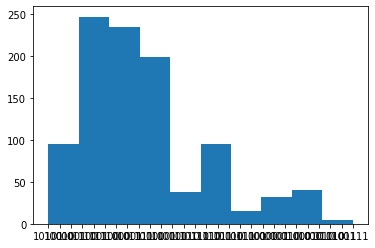

In [ ]:
n, input, init_vec = ReadInput('measure.circuit')
states = []
output = quantumCircuit(n, input, init_vec)
for i in range(1000):
  states.append(measure(output))

plt.hist(states)

### Simulator 1b

In [ ]:
def quantumCircuit2(n, myInput, initVec):
  output = initVec
  for i in range(0, len(myInput)):
    gate = myInput[i][0]
    wire = int(myInput[i][1])
    if(gate == 'P'):
      phase = float(myInput[i][2])
      output = np.dot(PhaseGate(wire, n, phase), output)
    elif(gate == 'H'):
      output = np.dot(HadamardArray(wire, n), output)
    elif(gate == 'CNOT'):
      wire2 = int(myInput[i][2])
      output = np.dot(CNOT(wire, wire2, n), output)

  output_clean = []
  for i in range(len(output)):
    if(abs(output[i].real) > 0.0001):
      output_clean.append(output[i])
    else:
      output_clean.append(0)

  state = VecToState(output_clean)
  return state

In [ ]:
n, input, init_vec = ReadInput('rand.circuit')
print(quantumCircuit2(n, input, init_vec))

[((0.14565796004368062+0.11348294333323077j), '00000'), ((0.043097550946832715-0.12184596055817096j), '00001'), ((-0.00017826157500440906+0.08005459383129264j), '00010'), ((0.05035629868818658-0.00728248979944324j), '00011'), ((0.07232672559216348-0.022619270303906334j), '00100'), ((-0.0344478481753866-0.04222821092998373j), '00101'), ((0.053947952411923586+0.00895438102819792j), '00110'), ((0.0017934458673294082-0.026754015134267256j), '00111'), ((0.13464628848368854-0.12560319656579133j), '01000'), ((-0.1040997208563847-0.06762381241864739j), '01001'), ((0.010652323173449756+0.07094564243091288j), '01010'), ((0.031536789559932436-0.03537779772012159j), '01011'), ((0.007920474449196663+0.2978985122057255j), '01100'), ((0.19608126814268645-0.05835344971980608j), '01101'), ((-0.11306530101030757-0.022843082802562566j), '01110'), ((0.025670653436355988+0.07563944999428007j), '01111'), ((0.0014746900019901598-0.03645903212646826j), '10000'), ((-0.01267392548655991+0.005514371048822526j), 

In [ ]:
n, input, init_vec = ReadInput('input.circuit')
print(quantumCircuit2(n, input, init_vec))

[((0.15409919900412566-0.03902314287347573j), '00000'), ((0.04895105577891026-0.0300185154958014j), '00001'), ((-0.02131981307535502+0.0877478741409022j), '00010'), ((-0.11160918928703437-0.2333281229311662j), '00011'), ((-0.03390125834814461-0.009674003342578097j), '00100'), ((-0.016746063710111687-0.13026586952891353j), '00101'), ((-0.195920985299143+0.009885177232733897j), '00110'), ((-0.09796097290238415+0.013475996833847516j), '00111'), ((-0.18082511268453239+0.014381045617727531j), '01000'), ((0.05382740960549373-0.06863464649457762j), '01001'), ((0.0010329113421169642-0.003455337432564619j), '01010'), ((-0.021540979121069167+0.017446135359182678j), '01011'), ((-0.007195884290384133+0.1595810315078976j), '01100'), ((-0.2230964998748638+0.07462898841821952j), '01101'), ((-0.037893779801458916+0.005859520326027601j), '01110'), ((0.07390340399259623-0.05074229743090869j), '01111'), ((-0.14804641063958537+0.08745635006745289j), '10000'), ((-0.06328890454391896+0.25662035423302665j), 

(array([273., 348.,  46., 130.,  53.,  36.,  47.,  51.,  10.,   6.]),
 array([ 0.,  3.,  6.,  9., 12., 15., 18., 21., 24., 27., 30.]),
 <a list of 10 Patch objects>)

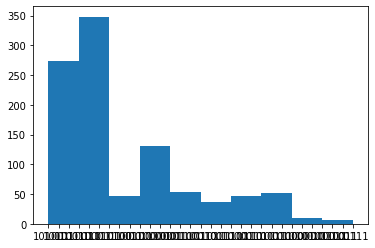

In [ ]:
n, input, init_vec = ReadInput('measure.circuit')
states = []
output = quantumCircuit2(n, input, init_vec)
for i in range(1000):
  states.append(measure(output))

plt.hist(states)

### Simulator 1c

In [ ]:
def HadamardArray3(i, k):
  size = 2**k
  myMatrix = np.zeros((size, size))
  identity = sc.csr_matrix(sc.identity(2,dtype='complex'))
  matrix_list = []
  hadamard = sc.csr_matrix([[1/np.sqrt(2), 1/np.sqrt(2)], [1/np.sqrt(2), -1/np.sqrt(2)]])
  for idx in range(k):
    if(idx == i):
      matrix_list.append(hadamard)
    else:
      matrix_list.append(identity)

  return TensorMe3(matrix_list)

In [ ]:
def quantumCircuit3(n, myInput, initVec):
  output = initVec
  for i in range(0, len(myInput)):
    gate = myInput[i][0]
    wire = int(myInput[i][1])
    if(gate == 'P'):
      phase = float(myInput[i][2])
      output = PhaseGate3(wire, n, phase) @ output
    elif(gate == 'H'):
      output = HadamardArray3(wire, n) @ output
    elif(gate == 'CNOT'):
      wire2 = int(myInput[i][2])
      output = CNOT3(wire, wire2, n) @ output

  output_clean = []

  for i in range(len(output)):
    if(output[i].real > 0.0001):
      output_clean.append(output[i])
    else:
      output_clean.append(0)

  state = VecToState(output_clean)
  return state

In [ ]:
def TensorMe3(matrix_list):
  myMatrix = matrix_list[0]
  for j in range(1,len(matrix_list)):
    myMatrix = sc.kron(myMatrix, matrix_list[j], format='csr')
  return myMatrix

In [ ]:
def PhaseGate3(i, k, theta):
  identity = sc.csr_matrix(sc.identity(2,dtype='complex'))
  matrix_list = []
  phase = sc.csr_matrix([[1, 0], [0, np.exp(1j*theta)]])
  for idx in range(k):
    if(idx == i):
      matrix_list.append(phase)
    else:
      matrix_list.append(identity)

  return TensorMe3(matrix_list)

In [ ]:
def CNOT3(i, j, k):
  identity = sc.csr_matrix(sc.identity(2,dtype='complex'))
  zero = sc.csr_matrix([[1.0], [0.0]])
  one = sc.csr_matrix([[0.0], [1.0]])
  X = sc.csr_matrix([[0.0, 1.0], [1.0, 0.0]])
  p0 = zero @ zero.T
  p1 = one @ one.T
  first = []
  second = []
  for idx in range(k):
    if(idx == i):
      first.append(p0)
      second.append(p1)
    elif(idx == j):
      second.append(X)
      first.append(identity)
    else:
      first.append(identity)
      second.append(identity)
  cnot = TensorMe3(first) + TensorMe3(second)
  return cnot

In [ ]:
n, input, init_vec = ReadInput('rand.circuit')
print(quantumCircuit3(n, input, init_vec))

[((0.14565796004368062+0.11348294333323078j), '00000'), ((0.0430975509468327-0.12184596055817092j), '00001'), ((0.05035629868818648-0.007282489799443195j), '00011'), ((0.07232672559216352-0.0226192703039063j), '00100'), ((0.05394795241192346+0.008954381028197953j), '00110'), ((0.0017934458673294837-0.026754015134267266j), '00111'), ((0.13464628848368843-0.12560319656579133j), '01000'), ((0.010652323173449808+0.07094564243091278j), '01010'), ((0.03153678955993242-0.03537779772012162j), '01011'), ((0.007920474449196552+0.2978985122057255j), '01100'), ((0.19608126814268645-0.058353449719806036j), '01101'), ((0.025670653436355974+0.07563944999428004j), '01111'), ((0.0014746900019901657-0.03645903212646838j), '10000'), ((0.016011739671690287+0.022594139337382385j), '10011'), ((0.27747135781393106+0.04232940722894608j), '10101'), ((0.007401893528164838+0.10788583514551445j), '10111'), ((0.03432507377519417+0.31797145079525097j), '11001')]


In [ ]:
n, input, init_vec = ReadInput('input.circuit')
print(quantumCircuit3(n, input, init_vec))

FileNotFoundError: ignored

In [ ]:
n, input, init_vec = ReadInput('measure.circuit')
states = []
output = quantumCircuit3(n, input, init_vec)
for i in range(1000):
  states.append(measure(output))

print(output)
#plt.hist(states)

[((0.14565796004368062+0.11348294333323078j), '00000'), ((0.0430975509468327-0.12184596055817092j), '00001'), ((0.05035629868818648-0.007282489799443195j), '00011'), ((0.07232672559216352-0.0226192703039063j), '00100'), ((0.05394795241192346+0.008954381028197953j), '00110'), ((0.0017934458673294837-0.026754015134267266j), '00111'), ((0.13464628848368843-0.12560319656579133j), '01000'), ((0.010652323173449808+0.07094564243091278j), '01010'), ((0.03153678955993242-0.03537779772012162j), '01011'), ((0.007920474449196552+0.2978985122057255j), '01100'), ((0.19608126814268645-0.058353449719806036j), '01101'), ((0.025670653436355974+0.07563944999428004j), '01111'), ((0.0014746900019901657-0.03645903212646838j), '10000'), ((0.016011739671690287+0.022594139337382385j), '10011'), ((0.27747135781393106+0.04232940722894608j), '10101'), ((0.007401893528164838+0.10788583514551445j), '10111'), ((0.03432507377519417+0.31797145079525097j), '11001')]


In [ ]:
def randomCircuit(n):
  circuit = []
  for i in range(n):
    rand = np.random.randint(1,4)
    randWire = np.random.randint(0, n)
    if(rand == 1):
      circuit.append(['H', randWire])
    if(rand == 2):
      wire2 = np.random.randint(0, n)
      circuit.append(['CNOT', randWire, wire2])
    if(rand == 3):
      theta = np.random.rand()
      circuit.append(['PHASE', randWire, theta])
  return circuit

## **Quantum Computing Simulator II**

In [ ]:
def Hadamard(inWire, numWires, inputState):
  matrix = HadamardArray(inWire, numWires)
  vec_state = StateToVec(inputState)
  out_vec = matrix @ vec_state
  out_state = VecToState(out_vec)
  return (out_state)

In [ ]:
def Phase(inWire, theta, numWires, inputState):
  matrix = PhaseGate(inWire, numWires, theta)
  vec_state = StateToVec(inputState)
  out_vec = matrix @ vec_state
  out_state = VecToState(out_vec)
  return (out_state)

In [ ]:
def cnot(control, target, numWires, inputState):
  matrix = CNOT(control, target, numWires)
  vec_state = StateToVec(inputState)
  out_vec = matrix @ vec_state
  out_state = VecToState(out_vec)
  return (out_state)

In [ ]:
myState=[
  (np.sqrt(0.1), '00'),
  (np.sqrt(0.4), '01') ,
  (-np.sqrt(0.5), '11' )
]

In [ ]:
def removeDuplicates(myState):
  output = []
  for element in myState:
    if(str(element[1]) not in str(myState)):
      output.append(element)
    else:
      total = 0
      for i in range(len(myState)):
        if(myState[i][1] == element[1]):
          total += float(myState[i][0])
      output.append((total, element[1]))
  return output

In [ ]:
newState = []
for i in range(len(myState)):
  newState += (Hadamard(i, len(myState[i][1]), myState))

print(newState)
print(removeDuplicates(newState))

[((0.22360679774997896+0j), '00'), ((-0.052786404500042065+0j), '01'), ((0.22360679774997896+0j), '10'), ((0.9472135954999579+0j), '11'), ((0.6708203932499369+0j), '00'), ((-0.22360679774997896+0j), '01'), ((-0.5+0j), '10'), ((0.5+0j), '11'), ((0.31622776601683794+0j), '00'), ((0.6324555320336759+0j), '01'), ((-0.7071067811865476+0j), '11')]
[(1.2106549570167537, '00'), (0.3560623297836549, '01'), (-0.27639320225002106, '10'), (0.7401068143134103, '11'), (1.2106549570167537, '00'), (0.3560623297836549, '01'), (-0.27639320225002106, '10'), (0.7401068143134103, '11'), (1.2106549570167537, '00'), (0.3560623297836549, '01'), (0.7401068143134103, '11')]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: ComplexWarning: Casting complex values to real discards the imaginary part
  # Remove the CWD from sys.path while we load stuff.


## **Non-atomic Gates**


In [ ]:
#not gate defined for simplicity in next parts
X = np.array([['H', 0], ['P', 0, -np.pi], ['H', 0]])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


In [ ]:
#NOT Gate from H and P
n = 1
init_vec = np.zeros(2**n)
init_vec[1] = 1
myInput = [['H', 0], ['P', 0, -np.pi], ['H', 0]]
print(quantumCircuit2(n, myInput, init_vec))

[((0.9999999999999998+6.123233995736765e-17j), '0')]


In [ ]:
#Rz Gate: not phase(neg theta) not phase(pos theta)
Rz = [['H', 0], ['P', 0, -np.pi], ['H', 0], ['P', 0, -np.pi/4], ['H', 0], ['P', 0, -np.pi], ['H', 0], ['P', 0, -np.pi/4]]
#print(quantumCircuit2(n, myInput, init_vec))

In [ ]:
#Control Rz gate: cnot phase cnot phase
CRz = [['CNOT', wire1, wire2], ['P', wire2, -theta/2], ['CNOT', wire1, wire2], ['P', wire2, theta/2]]

In [ ]:
#Control Phase gate
init_vec = np.zeros(2**2)
init_vec[1] = 1
theta = np.pi
CPhase = [['P', 0, theta/2], ['P', 1, theta/2], ['CNOT', 0, 1], ['P', 1, -theta/2], ['CNOT', 0, 1]]
print(quantumCircuit(2, myInput, init_vec))

[((1+0j), '01')]


In [ ]:
#Swap Gate: cnot cnot cnot
init_vec = np.zeros(2**n)
init_vec[2] = 1
print(VecToState(init_vec))
SWAP = [['CNOT', 0, 1], ['CNOT', 1, 0], ['CNOT', 0, 1]]
print(quantumCircuit2(n, myInput, init_vec))

[(1.0, '010')]
[(1.0, '100')]


In [ ]:
def precompile(myInput):
  output = []
  for input in myInput:
    gate = input[0]
    wire1 = input[1]
    if(gate == 'H' or gate == 'CNOT' or gate == 'P'):
      output.append(input)
    elif(gate == 'NOT'):
      output.extend([['H', wire1], ['P', wire1, -np.pi], ['H', wire1]])
    elif(gate == 'CRz'):
      wire2 = input[2]
      theta = input[3]
      output.extend( [['CNOT', wire1, wire2], ['P', wire2, -theta/2], ['CNOT', wire1, wire2], ['P', wire2, theta/2]])
    elif(gate == 'Rz'):
      theta = input[2]
      output.extend([['H', wire1], ['P', wire1, -np.pi], ['H', wire1], ['P', wire1, -theta/2], ['H', wire1], ['P', wire1, -np.pi], ['H', wire1], ['P', wire1, theta/2]])
    elif(gate == 'CPHASE'):
      wire2 = input[2]
      theta = input[3]
      output.extend([['P', wire1, theta/2], ['P', wire2, theta/2], ['CNOT', wire1, wire2], ['P', wire2, -theta/2], ['CNOT', wire1, wire2]])
    elif(gate == 'SWAP'):
      wire2 = input[2]
      output.extend([['CNOT', wire1, wire2], ['CNOT', wire2, wire1], ['CNOT', wire1, wire2]])

  return output

In [ ]:
n = 9
init_vec = np.zeros(2**n)
init_vec[1] = 1
myInput = [['H', 0], ['CPHASE', 0, 5, 0.3], ['P', 1, 0.3], ['CNOT', 4, 7], ['SWAP', 2, 8]]
out = precompile(myInput)
print(quantumCircuit2(n, out, init_vec))

[((0.7071067811865475+0j), '001000000'), ((0.7071067811865474+1.3877787807814457e-17j), '101000000')]


# **Week 2: Master Phase Estimation**

## **Phase Estimation**

In [ ]:
n = 2
init_vec = np.zeros(2**n)
init_vec[1] = 1
xs = np.linspace(0, 2*np.pi, num=100)
thetas = []
for x in xs:
  myInput = [['H', 0], ['CPHASE', 0, 1, x], ['H', 0]]
  newInput = precompile(myInput)
  output = quantumCircuit2(n, newInput, init_vec)
  max = -10000
  for i in range(len(output)):
    if(output[i][0].real > max):
      max = output[i][0].real
      num = output[i][1]
  if(num == '11'):
    thetas.append(1)
  elif(num == '01'):
    thetas.append(0)

print(thetas)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Text(0.5, 1.0, 'theta vs phi/2*pi')

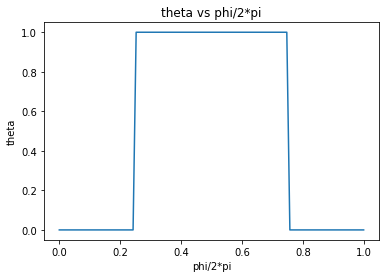

In [ ]:
plt.plot(xs/(2*np.pi), thetas)
plt.xlabel('phi/2*pi')
plt.ylabel('theta')
plt.title('theta vs phi/2*pi')

[((0.9948793792787674+0.07137506542667224j), '01'), ((0.00512062072123248-0.07137506542667223j), '11')]


(array([9941.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          59.]),
 array([0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55, 0.6 , 0.65, 0.7 , 0.75]),
 <a list of 10 Patch objects>)

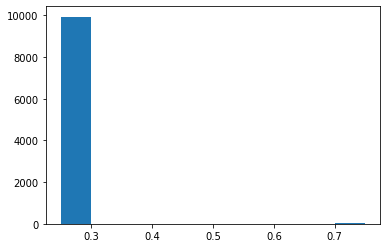

In [ ]:
n = 2
init_vec = np.zeros(2**n)
init_vec[1] = 1
x = 0.1432394487827058
thetas = []
myInput = [['H', 0], ['CPHASE', 0, 1, x], ['H', 0]]
newInput = precompile(myInput)
output = quantumCircuit2(n, newInput, init_vec)
print(output)
for i in range(10000):
  state = measure(output)
  if(state == '11'):
    thetas.append(1*(1/2) + 1*(1/4))
  elif(state == '01'):
    thetas.append(0*(1/2) + 1*(1/4))

plt.hist(thetas)

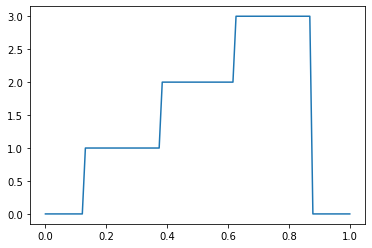

In [ ]:
n = 3
init_vec = np.zeros(2**n)
init_vec[1] = 1
xs = np.linspace(0, 2*np.pi, num=100)
thetas = []
for x in xs:
  myInput = [['H', 0], ['H', 1], ['CPHASE', 1, 2, x], ['CPHASE', 0, 2, x], ['CPHASE', 0, 2, x], ['H', 0], ['CPHASE', 0, 1, -np.pi/2], ['H', 1], ['SWAP', 0, 1]]
  newInput = precompile(myInput)
  output = quantumCircuit2(n, newInput, init_vec)
  max = -10000
  for i in range(len(output)):
    if(output[i][0].real > max):
      max = output[i][0].real
      state = output[i][1]
      idx = i
  thetas.append(binaryToDecimal(int(state[:len(state)-1])))

plt.plot(xs/(2*np.pi), thetas)
plt.show()

In [ ]:
def measure(output_state):
  probs = [0]
  for state in output_state:
    probs.append(abs(state[0])**2)
  num = np.random.rand()
  for i in range(1,len(probs)):
    if(num > np.sum(probs[:i]) and num <= np.sum(probs[:i]) + probs[i]):
      return output_state[i-1][1]

[((0.9645216714109671+0.21048532195571146j), '001'), ((-0.05827736045104982-0.09081300408714263j), '011'), ((0.01510072873038559-0.06919712965837957j), '101'), ((0.07865496030969675-0.05047518821018926j), '111')]


(array([968.,   0.,   0.,  16.,   0.,   0.,   6.,   0.,   0.,  10.]),
 array([0.125, 0.2  , 0.275, 0.35 , 0.425, 0.5  , 0.575, 0.65 , 0.725,
        0.8  , 0.875]),
 <a list of 10 Patch objects>)

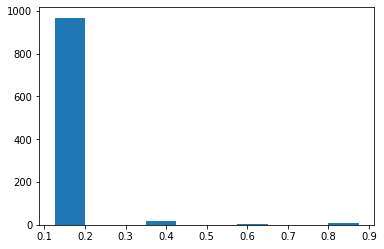

In [ ]:
x = 0.1432394487827058
n = 3
init_vec = np.zeros(2**n)
init_vec[1] = 1
thetas = []
myInput = [['H', 0], ['H', 1], ['CPHASE', 1, 2, x], ['CPHASE', 0, 2, x], ['CPHASE', 0, 2, x], ['H', 0], ['CPHASE', 0, 1, -np.pi/2], ['H', 1], ['SWAP', 0, 1]]
newInput = precompile(myInput)
output = quantumCircuit2(n, newInput, init_vec)
print(output)
for i in range(1000):
  theta = 0
  state = measure(output)
  for i in range(len(state)):
    theta = theta + float(state[i])*(2**(2-i)/2**n)
  thetas.append(theta)

plt.hist(thetas)

In [ ]:
def invert(input):
  output = []
  for x in input:
    gate = x[0]
    if(gate != 'CPHASE'):
      output.append(x)
    else:
      output.append(['CPHASE', x[1], x[2], -1*x[3]])
  return output

In [ ]:
def phaseEstimation(n, theta):
  matrix_list = []
  for i in range(n):
    matrix_list.append(['H', i])
  count = 1
  for j in range(n-1, -1, -1):
    for c in range(count):
      for i in range(n, n+3):
        matrix_list.append(['CPHASE', j, i, theta])
    count = count * 2
  inverse = invert(QFT(n))
  for x in inverse:
    matrix_list.append(x)
  for i in range(int(n/2)):
    matrix_list.append(['SWAP', i, n-i-1])
  return matrix_list

In [ ]:
print(phaseEstimation(6, np.pi))

[['H', 0], ['H', 1], ['H', 2], ['H', 3], ['H', 4], ['H', 5], ['CPHASE', 5, 6, 3.141592653589793], ['CPHASE', 5, 7, 3.141592653589793], ['CPHASE', 5, 8, 3.141592653589793], ['CPHASE', 4, 6, 3.141592653589793], ['CPHASE', 4, 7, 3.141592653589793], ['CPHASE', 4, 8, 3.141592653589793], ['CPHASE', 4, 6, 3.141592653589793], ['CPHASE', 4, 7, 3.141592653589793], ['CPHASE', 4, 8, 3.141592653589793], ['CPHASE', 3, 6, 3.141592653589793], ['CPHASE', 3, 7, 3.141592653589793], ['CPHASE', 3, 8, 3.141592653589793], ['CPHASE', 3, 6, 3.141592653589793], ['CPHASE', 3, 7, 3.141592653589793], ['CPHASE', 3, 8, 3.141592653589793], ['CPHASE', 3, 6, 3.141592653589793], ['CPHASE', 3, 7, 3.141592653589793], ['CPHASE', 3, 8, 3.141592653589793], ['CPHASE', 3, 6, 3.141592653589793], ['CPHASE', 3, 7, 3.141592653589793], ['CPHASE', 3, 8, 3.141592653589793], ['CPHASE', 2, 6, 3.141592653589793], ['CPHASE', 2, 7, 3.141592653589793], ['CPHASE', 2, 8, 3.141592653589793], ['CPHASE', 2, 6, 3.141592653589793], ['CPHASE', 2, 

[((0.03839038534842257+0.055990146912335774j), '000000111'), ((0.045993762709020294+0.07469021321625674j), '000001111'), ((0.0599184976714961+0.10893729246977689j), '000010111'), ((0.0939365857671942+0.19260281014074843j), '000011111'), ((0.30791194479957223+0.7188628142865974j), '000100111'), ((-0.1648283482038775-0.4438145597855258j), '000101111'), ((-0.05488048980578531-0.17340416917764315j), '000110111'), ((-0.028700499906283587-0.1090160001129754j), '000111111'), ((-0.0169233352694457-0.08005074570874801j), '001000111'), ((-0.010202194013994225-0.06352048801480698j), '001001111'), ((-0.005839277811004845-0.052790148271689034j), '001010111'), ((-0.0027661021543283434-0.04523185071286173j), '001011111'), ((-0.0004748013176530564-0.03959652899515931j), '001100111'), ((0.0013069480853620133-0.035214419520230286j), '001101111'), ((0.0027383151144363136-0.03169405520322985j), '001110111'), ((0.003918576105496544-0.028791271645078206j), '001111111'), ((0.004912881828310393-0.026345834300

(array([929.,  41.,   3.,   3.,   0.,   4.,   2.,   3.,   5.,  10.]),
 array([ 0. ,  6.3, 12.6, 18.9, 25.2, 31.5, 37.8, 44.1, 50.4, 56.7, 63. ]),
 <a list of 10 Patch objects>)

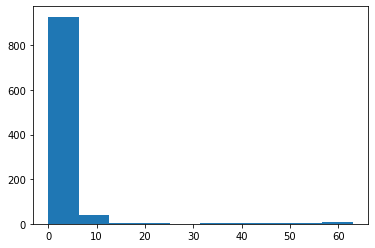

In [ ]:
x = 0.1432394487827058
n = 6 + 3
init_vec = np.zeros(2**n)
init_vec[7] = 1
thetas = []
myInput = phaseEstimation(6, x)
newInput = precompile(myInput)
output = quantumCircuit2(n, newInput, init_vec)
print(output)
for i in range(1000):
  theta = 0
  state = measure(output)
  thetas.append(binaryToDecimal(int(state[:len(state)-3])))

plt.hist(thetas)

[((0.999999999999999+0j), '000000001')]
[((-0.18330124690218888+0.40137374373095885j), '000000001'), ((0.37074482246447443-0.7165257216445682j), '000001001'), ((0.105975453962488-0.18230022694062184j), '000010001'), ((0.06611662120461886-0.10187700891933003j), '000011001'), ((0.04996801868727515-0.06929395289054896j), '000100001'), ((0.04119078258379029-0.0515841123374388j), '000101001'), ((0.035653878651749155-0.04041229416618115j), '000110001'), ((0.03182698504339133-0.032690766020114365j), '000111001'), ((0.029012148889141443-0.027011267498353177j), '001000001'), ((0.02684557065188394-0.022639759807858924j), '001001001'), ((0.025118977840323336-0.019156011275590915j), '001010001'), ((0.02370451446646228-0.016302046710442504j), '001011001'), ((0.022519323786071327-0.013910685953219563j), '001100001'), ((0.021507332508781184-0.011868789853964551j), '001101001'), ((0.020629219330183295-0.01009701976629622j), '001110001'), ((0.01985657637479721-0.008538057083392489j), '001111001'), ((0.

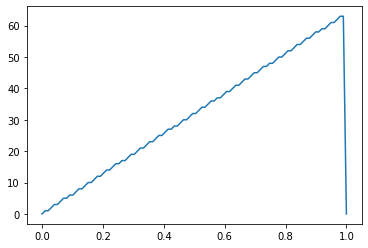

In [ ]:
xs = np.linspace(0, 2*np.pi, num=100)
thetas = []
n = 6 + 3
init_vec = np.zeros(2**n)
init_vec[1] = 1
for x in xs:
  myInput = phaseEstimation(6, x)
  newInput = precompile(myInput)
  output = quantumCircuit2(n, newInput, init_vec)
  print(output)
  max = -10000
  for i in range(len(output)):
    if(output[i][0].real > max):
      max = output[i][0].real
      idx = i
      state = output[i][1]
  thetas.append(binaryToDecimal(int(state[:len(state)-3])))

plt.plot(xs/(2*np.pi), thetas)

[((0.5477225575051654+1.5024689082067603e-16j), '000000000'), ((0.01461696870404526+0.0018531834305353175j), '000000111'), ((0.015334582189413323+0.0027144109243530824j), '000001111'), ((0.01614091614403928+0.0036821142703495693j), '000010111'), ((0.01705821586167004+0.004782990651580901j), '000011111'), ((0.01811655298587953+0.006053129866746301j), '000100111'), ((0.01935763754039934+0.007542589251636538j), '000101111'), ((0.020841094222928843+0.009322926030322847j), '000110111'), ((0.02265528664870078+0.011500187784746568j), '000111111'), ((0.024937063333702793+0.014238610147125842j), '001000111'), ((0.027910371897643154+0.017806958756901595j), '001001111'), ((0.03196876158832855+0.022677542787875416j), '001010111'), ((0.037873573058351345+0.02976406789851563j), '001011111'), ((0.04731479375834518+0.04109473406885159j), '001100111'), ((0.06494857601966704+0.062257516559845315j), '001101111'), ((0.10999402384085885+0.11631778566843141j), '001110111'), ((0.47733543292366193+0.557174218

(array([293.,   6., 684.,  11.,   2.,   1.,   1.,   1.,   0.,   1.]),
 array([ 0.,  6., 12., 18., 24., 30., 36., 42., 48., 54., 60.]),
 <a list of 10 Patch objects>)

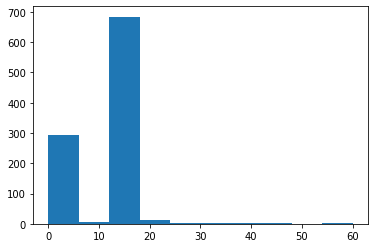

In [ ]:
x = 0.5
n = 6 + 3
init_vec = np.zeros(2**n)
init_vec[7] = np.sqrt(0.7)
init_vec[0] = np.sqrt(0.3)
thetas = []
myInput = phaseEstimation(6, x)
newInput = precompile(myInput)

output = quantumCircuit2(n, newInput, init_vec)
print(output)
for i in range(1000):
  theta = 0
  state = measure(output)
  thetas.append(binaryToDecimal(int(state[:len(state)-3])))

plt.hist(thetas)

## **Quantum Fourier Transform**

In [ ]:
n = 3
init_vec = np.zeros(2**n)
init_vec[4] = 1
myInput = [['H', 2], ['CPHASE', 1, 2, np.pi/2], ['H', 1], ['CPHASE', 0, 2, np.pi/4], ['CPHASE', 0, 1, np.pi/2], ['H', 0], ['SWAP', 0, 2]]
processed = precompile(myInput)
print(processed)
print(quantumCircuit(n, processed, init_vec, False))

[['H', 2], ['P', 1, 0.7853981633974483], ['P', 2, 0.7853981633974483], ['CNOT', 1, 2], ['P', 2, -0.7853981633974483], ['CNOT', 1, 2], ['H', 1], ['P', 0, 0.39269908169872414], ['P', 2, 0.39269908169872414], ['CNOT', 0, 2], ['P', 2, -0.39269908169872414], ['CNOT', 0, 2], ['P', 0, 0.7853981633974483], ['P', 1, 0.7853981633974483], ['CNOT', 0, 1], ['P', 1, -0.7853981633974483], ['CNOT', 0, 1], ['H', 0], ['CNOT', 0, 2], ['CNOT', 2, 0], ['CNOT', 0, 2]]
[((0.3535533905932736+7.727874229494942e-18j), '000'), ((-0.3535533905932736-7.727874229494942e-18j), '001'), ((0.24999999999999992+0.2499999999999999j), '100'), ((-0.24999999999999992-0.2499999999999999j), '101'), ((-0.2499999999999999+0.24999999999999992j), '110'), ((0.2499999999999999-0.24999999999999992j), '111')]


In [ ]:
n = 3
init_vec = np.zeros(2**n)
init_vec[4] = 1
myInput = [['H', 0], ['CPHASE', 1, 0, np.pi/2], ['CPHASE', 2, 0, np.pi/4], ['H', 1], ['CPHASE', 2, 1, np.pi/2], ['H', 2], ['SWAP', 0, 2]]
processed = precompile(myInput)
print(processed)
print(quantumCircuit(n, processed, init_vec, False))

[['H', 0], ['P', 1, 0.7853981633974483], ['P', 0, 0.7853981633974483], ['CNOT', 1, 0], ['P', 0, -0.7853981633974483], ['CNOT', 1, 0], ['P', 2, 0.39269908169872414], ['P', 0, 0.39269908169872414], ['CNOT', 2, 0], ['P', 0, -0.39269908169872414], ['CNOT', 2, 0], ['H', 1], ['P', 2, 0.7853981633974483], ['P', 1, 0.7853981633974483], ['CNOT', 2, 1], ['P', 1, -0.7853981633974483], ['CNOT', 2, 1], ['H', 2], ['CNOT', 0, 2], ['CNOT', 2, 0], ['CNOT', 0, 2]]
[((0.3535533905932737+0j), '000'), ((-0.3535533905932736-2.2002636261289807e-19j), '001'), ((0.3535533905932737+1.1496735851465464e-17j), '010'), ((-0.3535533905932736-2.2002636261289807e-19j), '011'), ((0.3535533905932737+0j), '100'), ((-0.3535533905932736-2.2002636261289807e-19j), '101'), ((0.3535533905932737+0j), '110'), ((-0.3535533905932737+0j), '111')]


In [ ]:
def QFT(n):
  output = []
  for i in range(n):
    output.append(['H', i])
    for j in range(i+1, n):
      output.append(['CPHASE', i, j, np.pi/(2**(j-i))])
  return output

In [ ]:
input = (QFT(5))
init_vec = initVec('inputState.txt')
print(len(init_vec))
print(quantumCircuit(n, input, init_vec))

32
[((-0.04028017284397896-0.22092218580979772j), '00000'), ((-0.033749535595862634+0.07942275396910152j), '00001'), ((0.051199962727666165-0.1491933481788422j), '00010'), ((0.047326730253510405+0.18554605787131015j), '00011'), ((0.10223179873715936+0.016381353606700268j), '00100'), ((0.09539624740606932-0.13544391503529615j), '00101'), ((0.17781300243802653-0.012041430020261229j), '00110'), ((0.14970991386459095+0.1694349842229165j), '00111'), ((0.07201759655232541-0.10145146835366997j), '01000'), ((-0.03888906393817565-0.15055364512485425j), '01001'), ((0.14891806346239933+0.062101606927073255j), '01010'), ((-0.23147400777843097-0.01825302224616898j), '01011'), ((0.10633809564429367-0.01945057561590411j), '01100'), ((-0.11037104730597863-0.09619564838074637j), '01101'), ((-0.1604425358281934+0.025468264790815175j), '01110'), ((-0.14239025859318005+0.02119004490653731j), '01111'), ((0.05374048631870436-0.3212806436070379j), '10000'), ((-0.1135827551576049-0.08494620987963418j), '10001

# **Week 3: Shor's Algorithm**

## **Classical Shor's**

In [ ]:
def isEasy(x):
  if(x % 2 == 0):
    return [x/2, 2.0]
  for i in range(2,int(math.log(x, 2) + 1)):
    if(round(x**(1/i),2).is_integer()):
      return [round(x**(1/i),2), round(x**(1/i),2)**(i-1)]

  return [0]

In [ ]:
def isImpossible(x):
  return sympy.isprime(x)

In [ ]:
def Shors(N):
  factors = isEasy(N)
  if(len(factors) > 1):
    return factors
  if(isImpossible(N)):
    return 'This is a prime number.'

  r = 3
  while(r % 2 != 0):
    x = np.random.randint(1, np.sqrt(N))
    if(math.gcd(x, N) == 1):
      for i in range(1,N):
        if((x**i) % N == 1):
          r = i
          print('x, r', x, r)
          break
    else:
      return [math.gcd(x, N), N/math.gcd(x, N)]

  factor1 = math.gcd(int((x**(r/2)-1)), N)
  factor2 = (math.gcd(int((x**(r/2)+1)), N))
  if(factor1 == 1 or factor2 == 1):
    output = Shors(N)
  else:
    output = [factor1, factor2]
  return output


In [ ]:
print('21', Shors(21))
print('51', Shors(51))
print('57', Shors(57))
print('63', Shors(63))
print('87', Shors(87))

21 [3, 7.0]
x, r 1 1
x, r 1 1
x, r 2 8
51 [3, 17]
x, r 4 9
57 [3, 19.0]
x, r 2 6
63 [7, 9]
x, r 1 1
x, r 7 7
x, r 2 28
87 [3, 29]


In [ ]:
print(Shors(99))
print(Shors(69))
print(Shors(93))
print(Shors(95))
print(Shors(91))

x, r 1 1
x, r 8 10
[3, 33.0]
x, r 5 22
x, r 2 22
[23, 3]
[3, 31.0]
x, r 7 12
[19, 5]
[7, 13.0]


## **Period Finding with Quantum Mechanics**

In [ ]:
def controlU(i, j, k, x, N):
  identity = np.eye(2)
  zero = np.array([[1.0], [0.0]])
  one = np.array([[0.0], [1.0]])
  if(j < N):
    p = np.array([[1.0, 0.0], [0.0, x % N]], dtype=np.complex)
  else:
    p = np.array([[1.0, 0.0], [0.0, 1.0]])
  p0 = np.dot(zero, zero.T)
  p1 = np.dot(one, one.T)
  first = []
  second = []
  for idx in range(k):
    if(idx == i):
      first.append(p0)
      second.append(p1)
    elif(idx == j):
      second.append(p)
      first.append(identity)
    else:
      first.append(identity)
      second.append(identity)
  cnot = TensorMe(first) + TensorMe(second)
  return cnot

In [ ]:
def periodFinding(x, N):
  n = 3
  matrix_list = []
  for i in range(n):
    matrix_list.append(['H', i])
  count = 1
  for j in range(n-1, -1, -1):
    for c in range(count):
      for i in range(n, n+3):
        matrix_list.append(['controlU', j, i, x, N])
    count = count * 2
  inverse = invert(QFT(n))
  for x in inverse:
    matrix_list.append(x)
  for i in range(int(n/2)):
    matrix_list.append(['SWAP', i, n-i-1])
  return matrix_list

given number x and N, U is 2^n where n = [logN]
given state
only have one entry which corresponds to input state
np.eig of matrix
np.angle of eigs to get phase
gives in form of s/i

In [ ]:
print(periodFinding(2, 6))

[['H', 0], ['H', 1], ['H', 2], ['controlU', 2, 3, 2, 6], ['controlU', 2, 4, 2, 6], ['controlU', 2, 5, 2, 6], ['controlU', 1, 3, 2, 6], ['controlU', 1, 4, 2, 6], ['controlU', 1, 5, 2, 6], ['controlU', 1, 3, 2, 6], ['controlU', 1, 4, 2, 6], ['controlU', 1, 5, 2, 6], ['controlU', 0, 3, 2, 6], ['controlU', 0, 4, 2, 6], ['controlU', 0, 5, 2, 6], ['controlU', 0, 3, 2, 6], ['controlU', 0, 4, 2, 6], ['controlU', 0, 5, 2, 6], ['controlU', 0, 3, 2, 6], ['controlU', 0, 4, 2, 6], ['controlU', 0, 5, 2, 6], ['controlU', 0, 3, 2, 6], ['controlU', 0, 4, 2, 6], ['controlU', 0, 5, 2, 6], ['H', 0], ['CPHASE', 0, 1, -1.5707963267948966], ['CPHASE', 0, 2, -0.7853981633974483], ['H', 1], ['CPHASE', 1, 2, -1.5707963267948966], ['H', 2], ['SWAP', 0, 2]]


In [ ]:
def quantumCircuit2(n, myInput, initVec):
  output = initVec
  for i in range(0, len(myInput)):
    gate = myInput[i][0]
    wire = int(myInput[i][1])
    if(gate == 'P'):
      phase = float(myInput[i][2])
      output = np.dot(PhaseGate(wire, n, phase), output)
    elif(gate == 'H'):
      output = np.dot(HadamardArray(wire, n), output)
    elif(gate == 'CNOT'):
      wire2 = int(myInput[i][2])
      output = np.dot(CNOT(wire, wire2, n), output)
    elif(gate == 'controlU'):
      wire2 = int(myInput[i][2])
      theta = float(myInput[i][3])
      output = np.dot(controlU(wire, wire2, ))

  output_clean = []
  for i in range(len(output)):
    if(abs(output[i].real) > 0.0001):
      output_clean.append(output[i])
    else:
      output_clean.append(0)

  state = VecToState(output_clean)
  return state